# 1. Libraries import



In [ ]:
!pip install gdown
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import gdown
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedKFold, cross_validate

# 2. Data download and pre-processing




##  2.2 Downloading datasets





In [ ]:

# The link toward our dataset
url = 'https://drive.google.com/drive/folders/1InpGH0UdP5aCn6KXu3XA8c6v4Audb_xW?usp=sharing'
output = './'

gdown.download_folder(url, output=output, quiet=False)


Retrieving folder contents


Processing file 1_v8nXtCPrcZkiT5Dvs1V5fGlPtTQrrDr age-insee-2020.xlsx
Processing file 1xCg9vxZQY4aQbN9Lj5wgIrGbSutph9Ay communes-france-2022.csv
Processing file 1OtPMR-jfxr_zZt1mVIqQWMAn74pXaLWO MDB-INSEE-V2.xls
Processing file 1aTJBSPxYsXMnjBk_IPMER2ahGKBFV7oR Niveau_de_vie_2013_a_la_commune.xlsx
Processing file 1E4sxnDatnyn-QyJMcjn7RaqHaTnQkWqn results_test.csv
Processing file 1pl2UFDNGVnq768EyVzN6_PEMo3dgKewa results_train.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1_v8nXtCPrcZkiT5Dvs1V5fGlPtTQrrDr
To: /content/datasets_intro_ml/age-insee-2020.xlsx
100%|██████████| 10.6M/10.6M [00:00<00:00, 40.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xCg9vxZQY4aQbN9Lj5wgIrGbSutph9Ay
To: /content/datasets_intro_ml/communes-france-2022.csv
100%|██████████| 14.8M/14.8M [00:00<00:00, 72.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OtPMR-jfxr_zZt1mVIqQWMAn74pXaLWO
To: /content/datasets_intro_ml/MDB-INSEE-V2.xls
100%|██████████| 57.1M/57.1M [00:00<00:00, 67.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aTJBSPxYsXMnjBk_IPMER2ahGKBFV7oR
To: /content/datasets_intro_ml/Niveau_de_vie_2013_a_la_commune.xlsx
100%|██████████| 1.51M/1.51M [00:00<00:00, 14.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E4sxnDatnyn-QyJMcjn7RaqHaTnQkWqn
To: /content/datasets_intro_ml

['./datasets_intro_ml/age-insee-2020.xlsx',
 './datasets_intro_ml/communes-france-2022.csv',
 './datasets_intro_ml/MDB-INSEE-V2.xls',
 './datasets_intro_ml/Niveau_de_vie_2013_a_la_commune.xlsx',
 './datasets_intro_ml/results_test.csv',
 './datasets_intro_ml/results_train.csv']


##  2.3 Data pre-processing and visualisation




In [ ]:
# ----- Loading of data file -----
data_path = './datasets_intro_ml/'
assert os.path.exists(data_path), "Le dossier datasets_intro_ml n'existe pas."

results_train = pd.read_csv(os.path.join(data_path, 'results_train.csv'), dtype={"CodeINSEE": str}, low_memory=False, encoding='utf-8')
results_train.head()

,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,...,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,01006,Ain,Ambléon,Complet,103,19,18.45,84,81.55,12,...,45,43.69,62.50,2,F,LE PEN,Marine,27,26.21,37.50
1,01009,Ain,Andert-et-Condon,Complet,280,73,26.07,207,73.93,22,...,102,36.43,56.04,2,F,LE PEN,Marine,80,28.57,43.96
2,01010,Ain,Anglefort,Complet,792,185,23.36,607,76.64,31,...,227,28.66,39.96,2,F,LE PEN,Marine,341,43.06,60.04
3,01011,Ain,Apremont,Complet,289,42,14.53,247,85.47,29,...,101,34.95,47.20,2,F,LE PEN,Marine,113,39.10,52.80
4,01012,Ain,Aranc,Complet,283,76,26.86,207,73.14,28,...,92,32.51,53.18,2,F,LE PEN,Marine,81,28.62,46.82


In [ ]:
niveau_de_vie = pd.read_excel(os.path.join(data_path, 'Niveau_de_vie_2013_a_la_commune.xlsx'))


# Replace the Code Commune by CodeINSEE name and ensure it is a string on 5 characters
niveau_de_vie['Code Commune'] = niveau_de_vie['Code Commune'].apply(lambda x: str(x).zfill(5))
niveau_de_vie = niveau_de_vie.rename(columns={'Code Commune': 'CodeINSEE'})
niveau_de_vie['CodeINSEE'] = niveau_de_vie['CodeINSEE'].astype(str)
assert all(niveau_de_vie['CodeINSEE'].apply(lambda x: len(x) == 5))
assert all(results_train['CodeINSEE'].apply(lambda x: len(x) == 5))
niveau_de_vie

,CodeINSEE,Nom Commune,Niveau de vie Commune,Niveau de vie Département
0,05047,Éourres,10021.250000,19202.516480
1,26142,Glandage,10215.000000,19300.504181
2,11317,Rodome,10908.500000,17599.733068
3,11384,Soulatgé,11485.166667,17599.733068
4,30153,Malons-et-Elze,11680.000000,18282.543539
...,...,...,...,...
36567,91526,Roinvilliers,NaN,23141.927413
36568,74203,Novel,NaN,24707.911366
36569,78264,Gambaiseuil,NaN,26305.343074
36570,78606,Le Tartre-Gaudran,NaN,26305.343074


In [ ]:


# ----- Merging of datasets -----
data = results_train.merge(niveau_de_vie, on='CodeINSEE', how='left')

# ----- Exploratory Data Analysis on the Merged Dataset -----
print("\nInformations générales :")
data.info()


print("\nAperçu des données fusionnées :")
data


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20892 entries, 0 to 20891
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CodeINSEE                  20892 non-null  object 
 1   Libellé du département     20892 non-null  object 
 2   Libellé de la commune      20892 non-null  object 
 3   Etat saisie                20892 non-null  object 
 4   Inscrits                   20892 non-null  int64  
 5   Abstentions                20892 non-null  int64  
 6   % Abs/Ins                  20892 non-null  float64
 7   Votants                    20892 non-null  int64  
 8   % Vot/Ins                  20892 non-null  float64
 9   Blancs                     20892 non-null  int64  
 10  % Blancs/Ins               20892 non-null  float64
 11  % Blancs/Vot               20892 non-null  float64
 12  Nuls                       20892 non-null  int64  
 13  % Nuls/Ins          

,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Nom Commune,Niveau de vie Commune,Niveau de vie Département
0,01006,Ain,Ambléon,Complet,103,19,18.45,84,81.55,12,...,2,F,LE PEN,Marine,27,26.21,37.50,Ambléon,21871.666667,22343.574665
1,01009,Ain,Andert-et-Condon,Complet,280,73,26.07,207,73.93,22,...,2,F,LE PEN,Marine,80,28.57,43.96,Andert-et-Condon,21486.250000,22343.574665
2,01010,Ain,Anglefort,Complet,792,185,23.36,607,76.64,31,...,2,F,LE PEN,Marine,341,43.06,60.04,Anglefort,21015.333333,22343.574665
3,01011,Ain,Apremont,Complet,289,42,14.53,247,85.47,29,...,2,F,LE PEN,Marine,113,39.10,52.80,Apremont,22690.000000,22343.574665
4,01012,Ain,Aranc,Complet,283,76,26.86,207,73.14,28,...,2,F,LE PEN,Marine,81,28.62,46.82,Aranc,20211.000000,22343.574665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20887,95652,Val-d'Oise,Viarmes,Complet,4026,1106,27.47,2920,72.53,165,...,2,F,LE PEN,Marine,1276,31.69,47.29,Viarmes,24955.428571,21296.219805
20888,95656,Val-d'Oise,Vienne-en-Arthies,Complet,332,58,17.47,274,82.53,22,...,2,F,LE PEN,Marine,105,31.63,42.51,Vienne-en-Arthies,25266.000000,21296.219805
20889,95680,Val-d'Oise,Villiers-le-Bel,Complet,12414,5099,41.07,7315,58.93,452,...,2,F,LE PEN,Marine,2161,17.41,32.24,Villiers-le-Bel,14212.857143,21296.219805
20890,95682,Val-d'Oise,Villiers-le-Sec,Complet,110,26,23.64,84,76.36,3,...,2,F,LE PEN,Marine,30,27.27,37.50,Villiers-le-Sec,25350.476190,21296.219805


In [ ]:

# ----- Analysis of missing values -----
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_percentage = 100 * data.isnull().sum() / len(data)
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
print("\nTableau des valeurs manquantes :")
missing_df


Tableau des valeurs manquantes :


,Missing Values,Percentage (%)
% Abs/Ins,0,0.000000
% Blancs/Ins,0,0.000000
% Blancs/Vot,0,0.000000
% Exp/Ins,0,0.000000
% Exp/Vot,0,0.000000
% Nuls/Ins,0,0.000000
% Nuls/Vot,0,0.000000
% Voix/Exp,0,0.000000
% Voix/Ins,0,0.000000
% Vot/Ins,0,0.000000


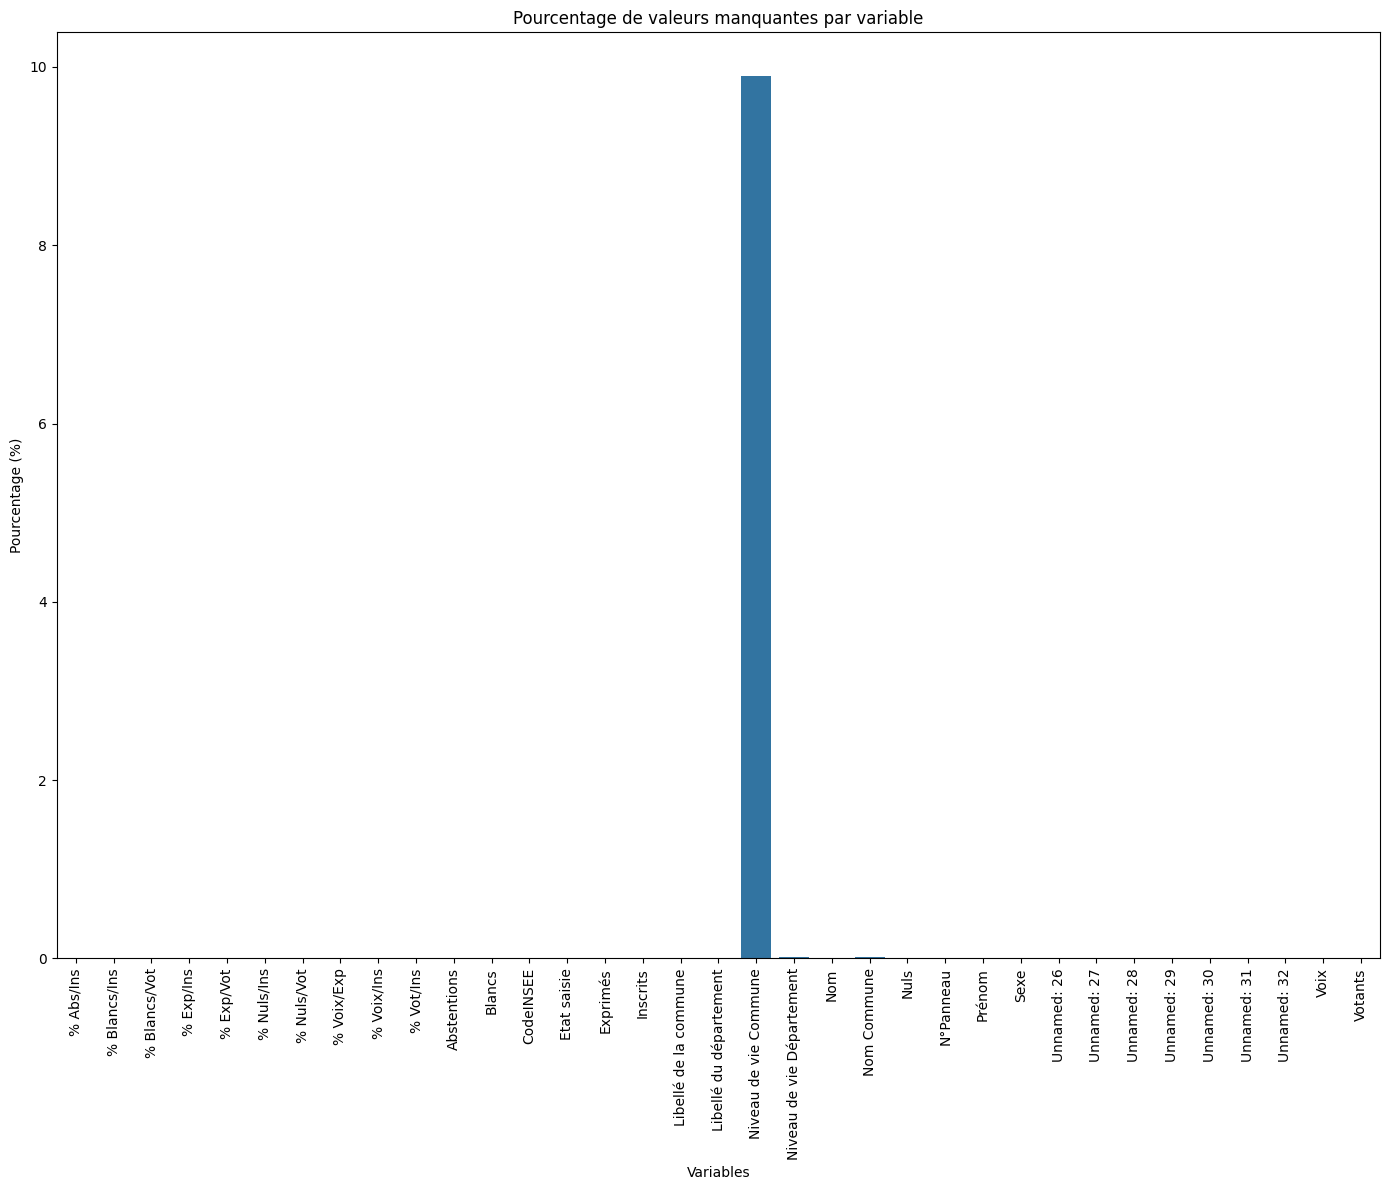

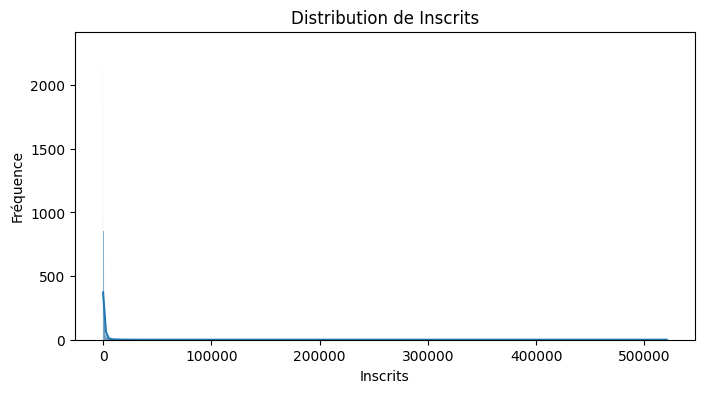

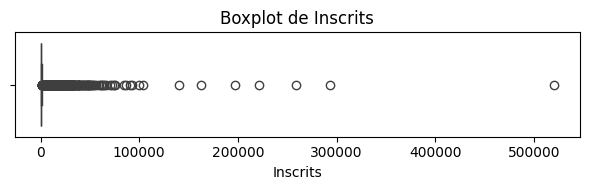

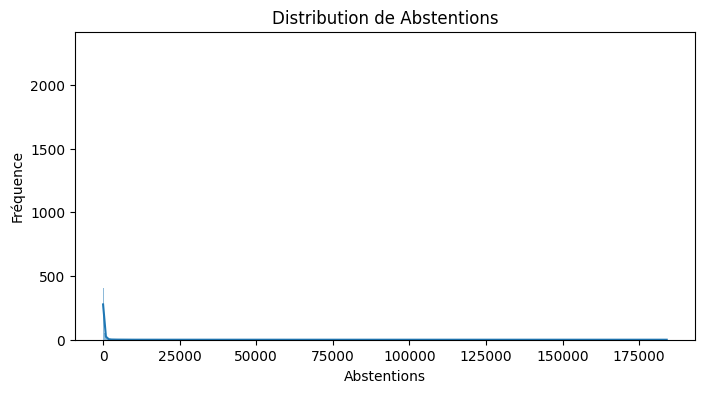

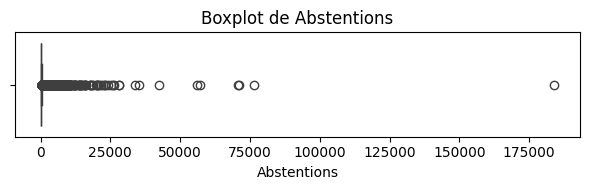

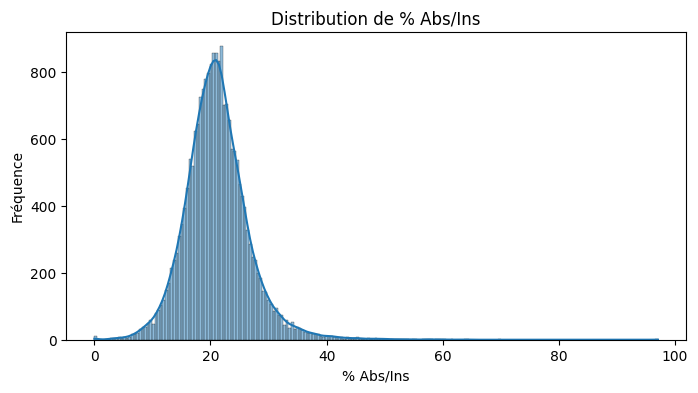

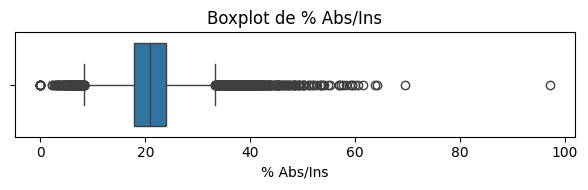

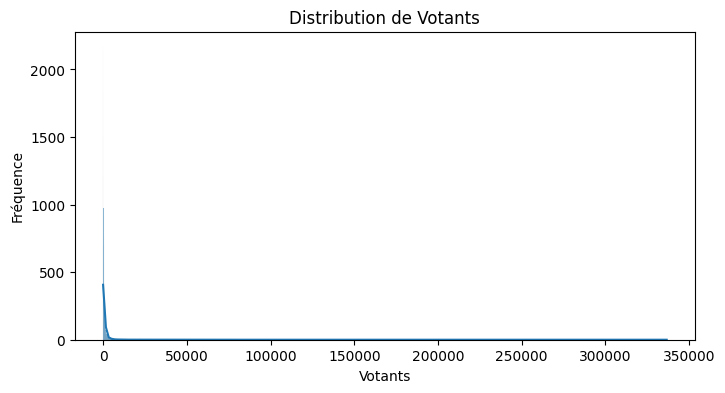

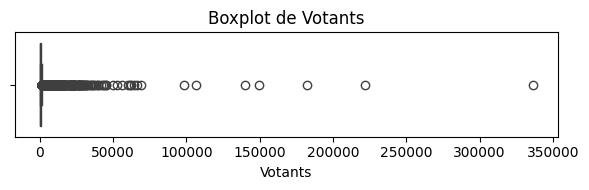

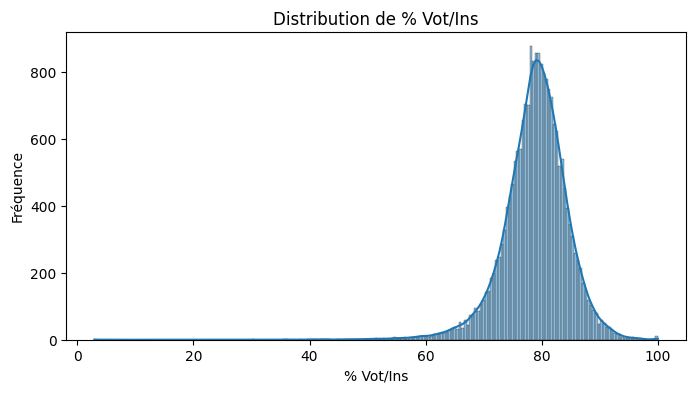

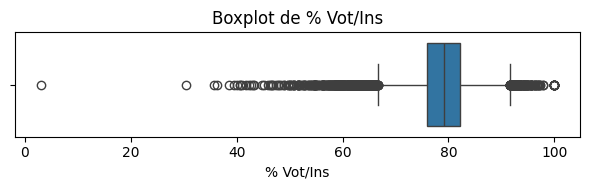

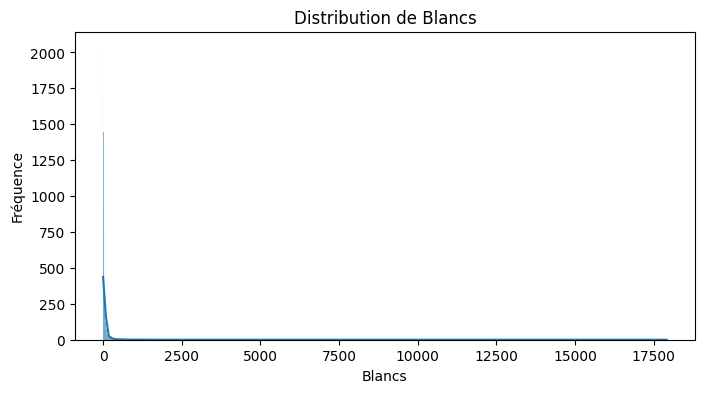

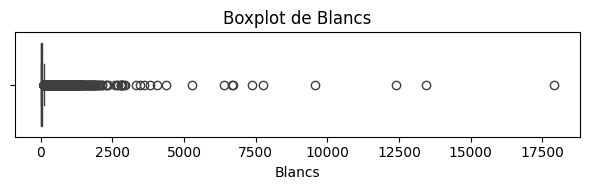

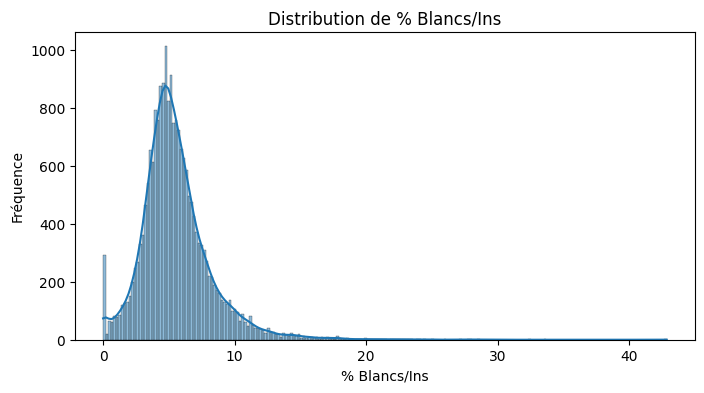

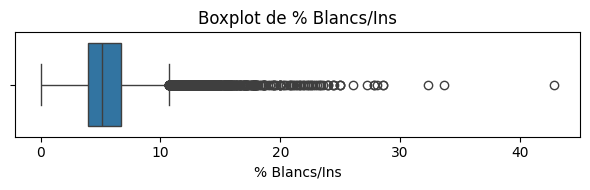

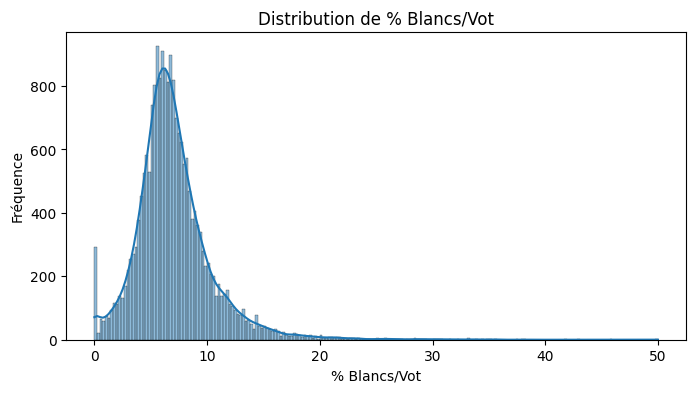

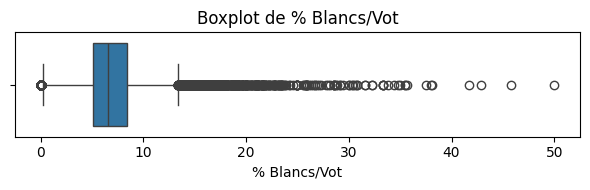

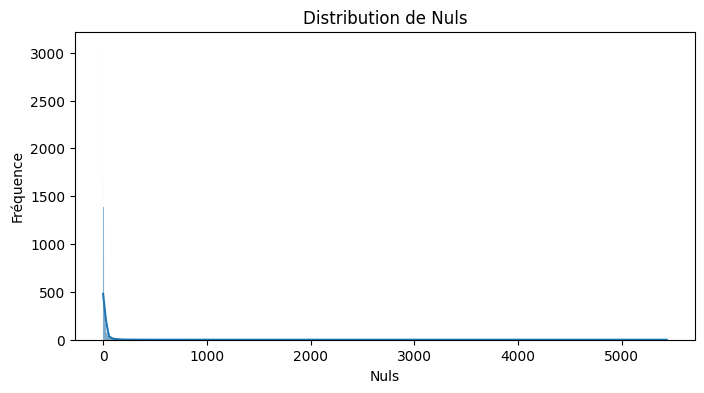

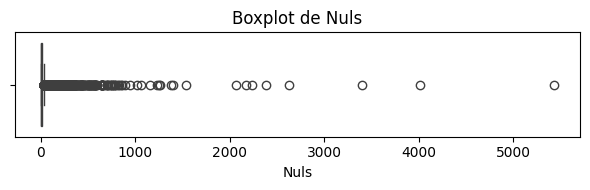

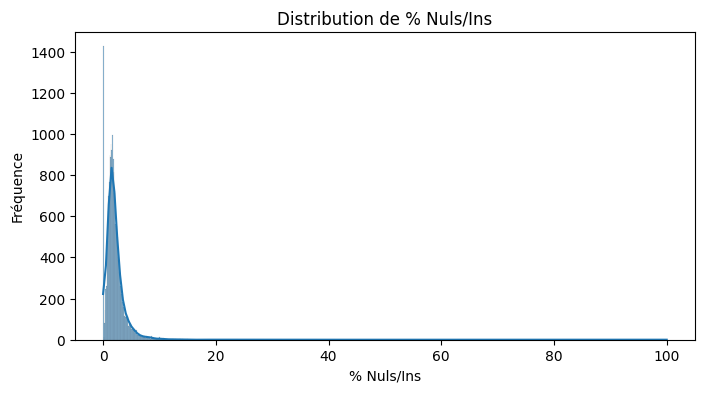

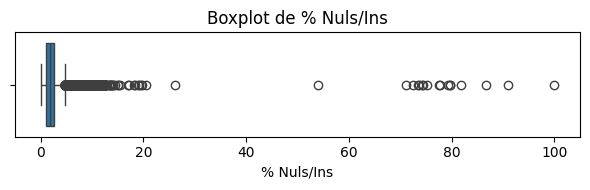

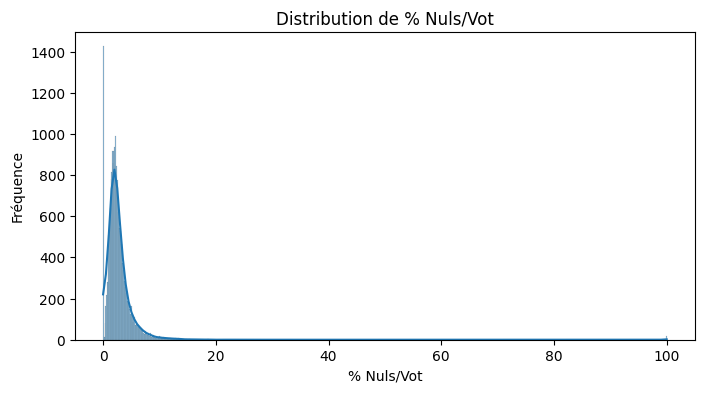

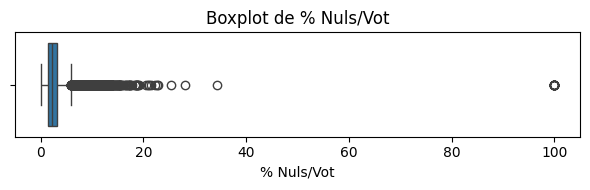

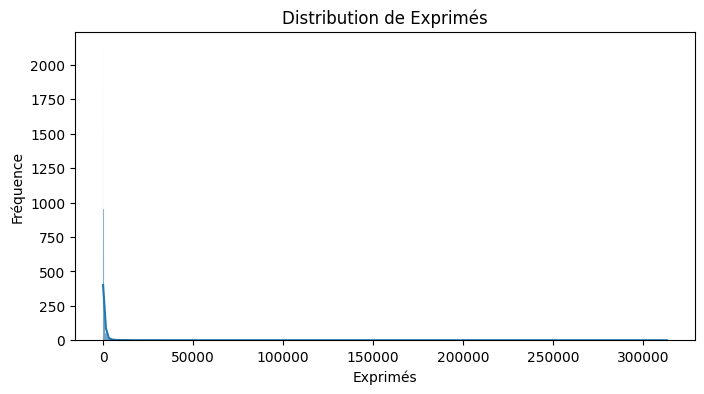

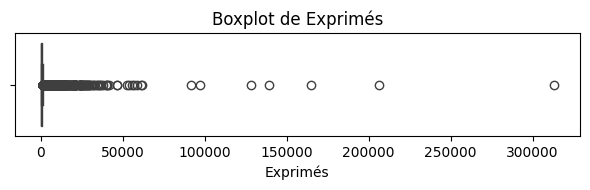

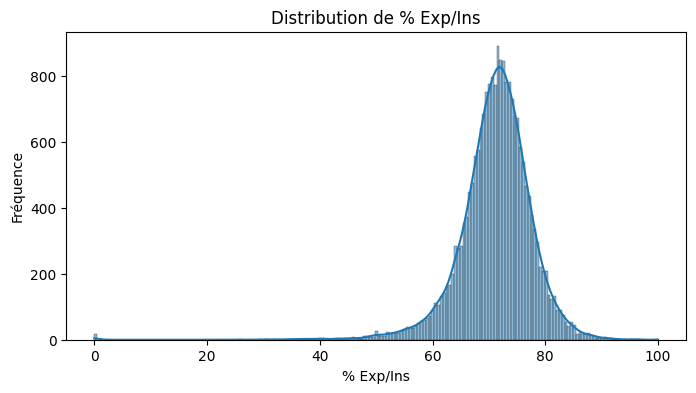

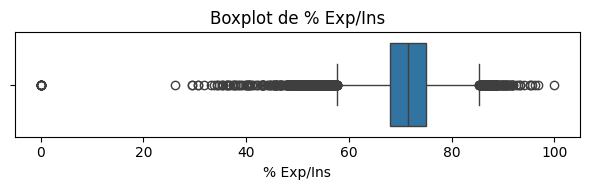

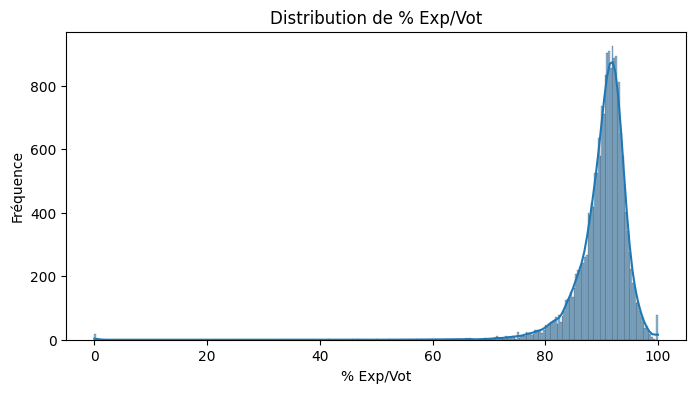

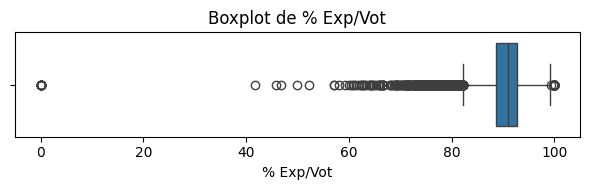

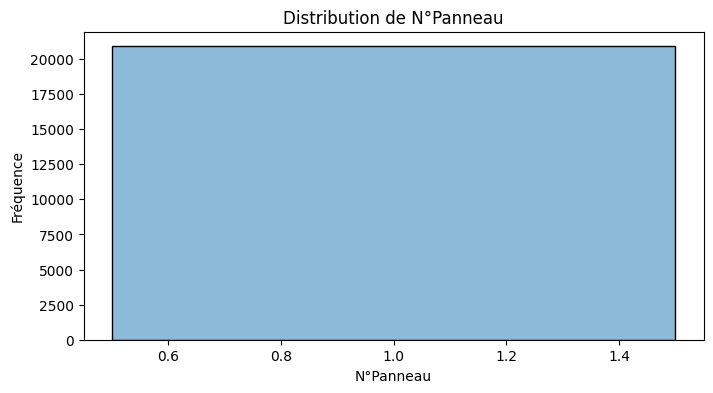

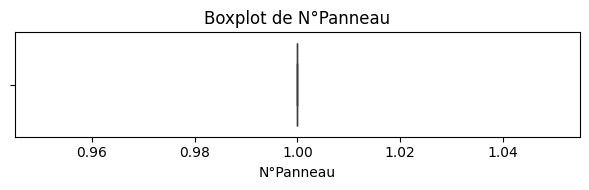

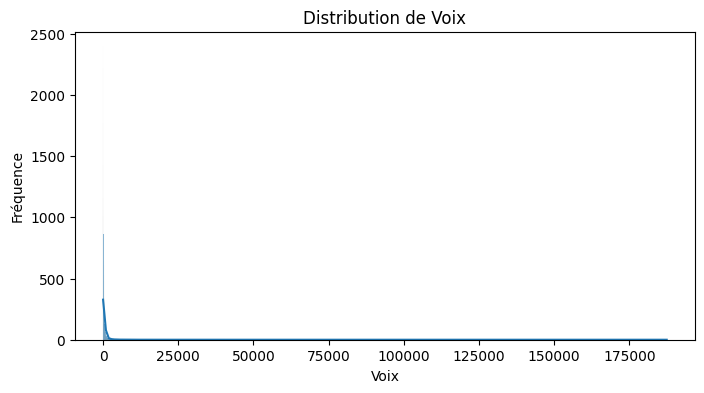

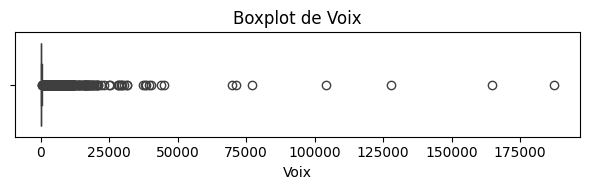

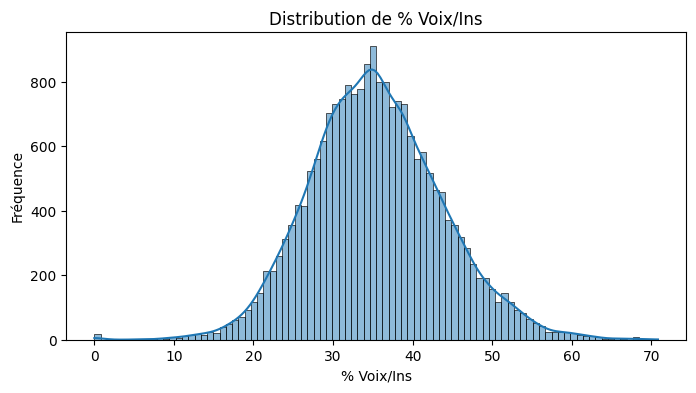

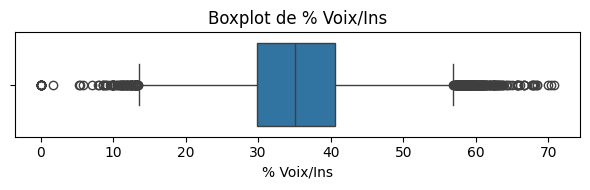

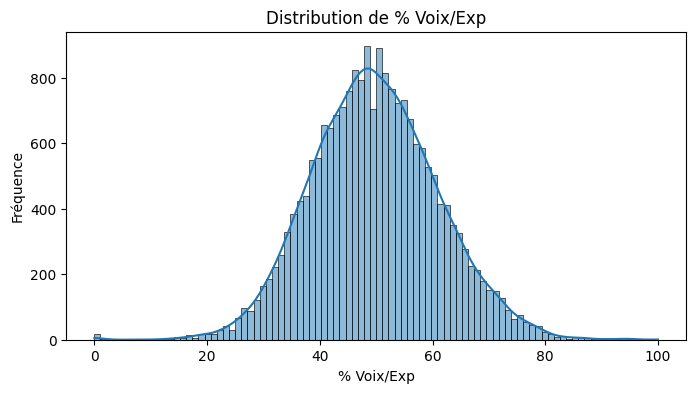

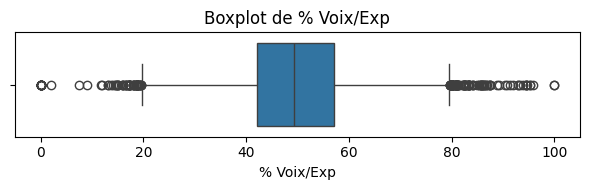

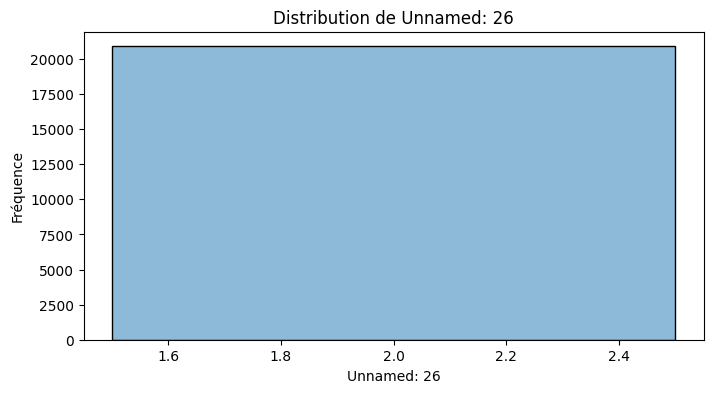

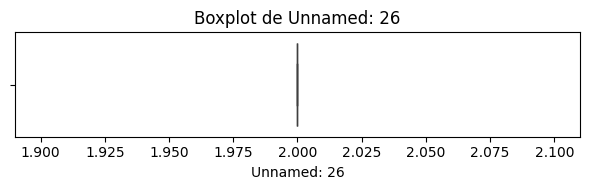

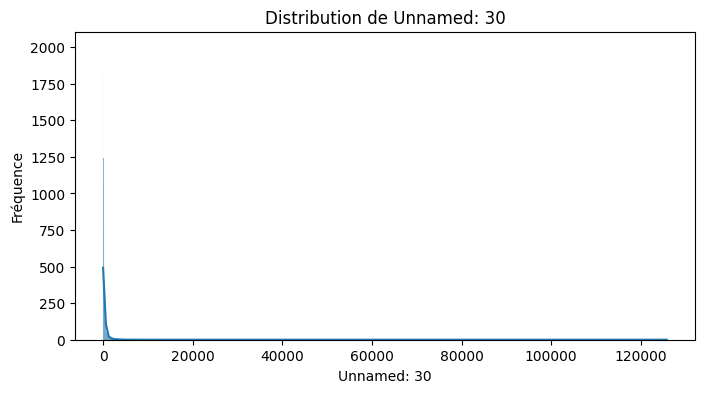

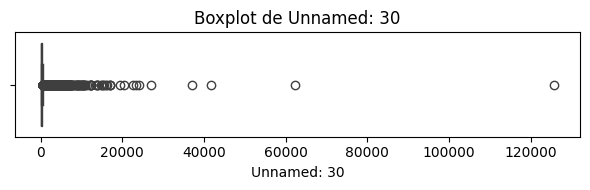

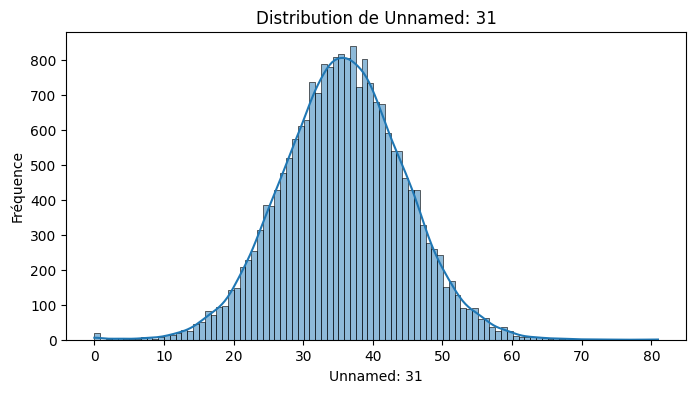

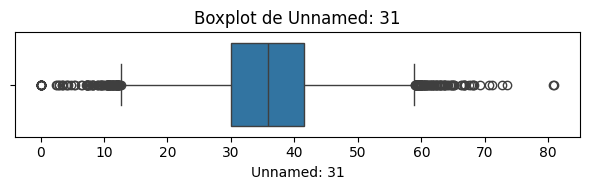

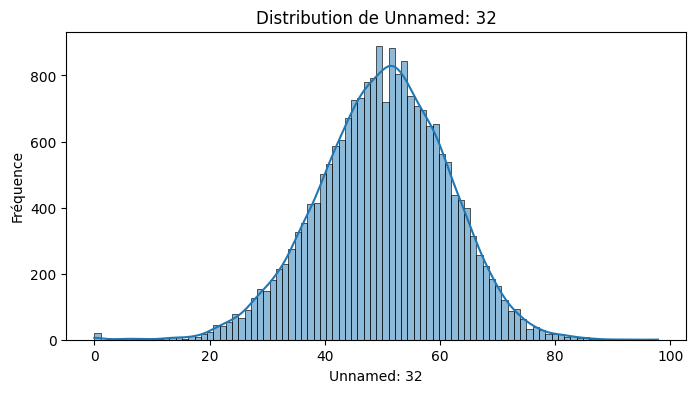

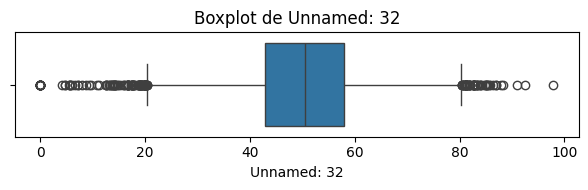

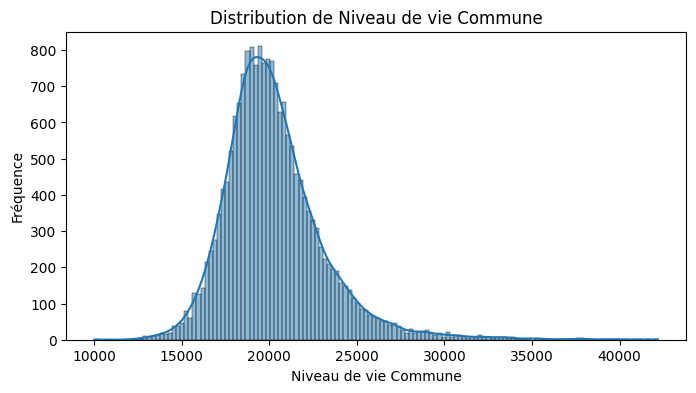

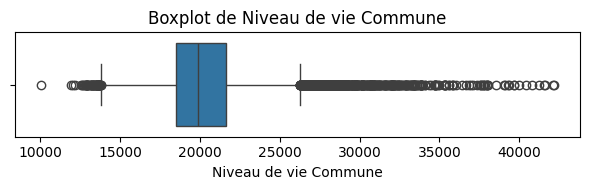

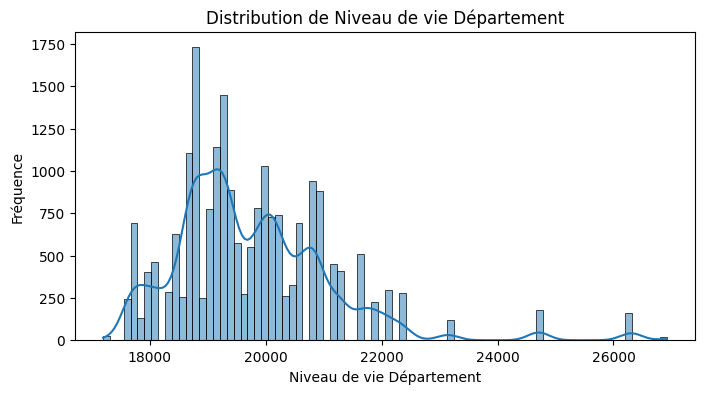

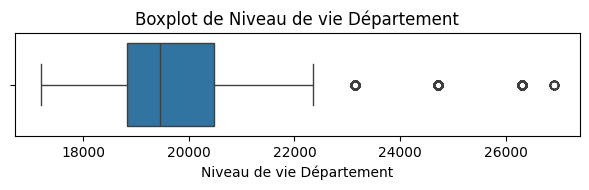

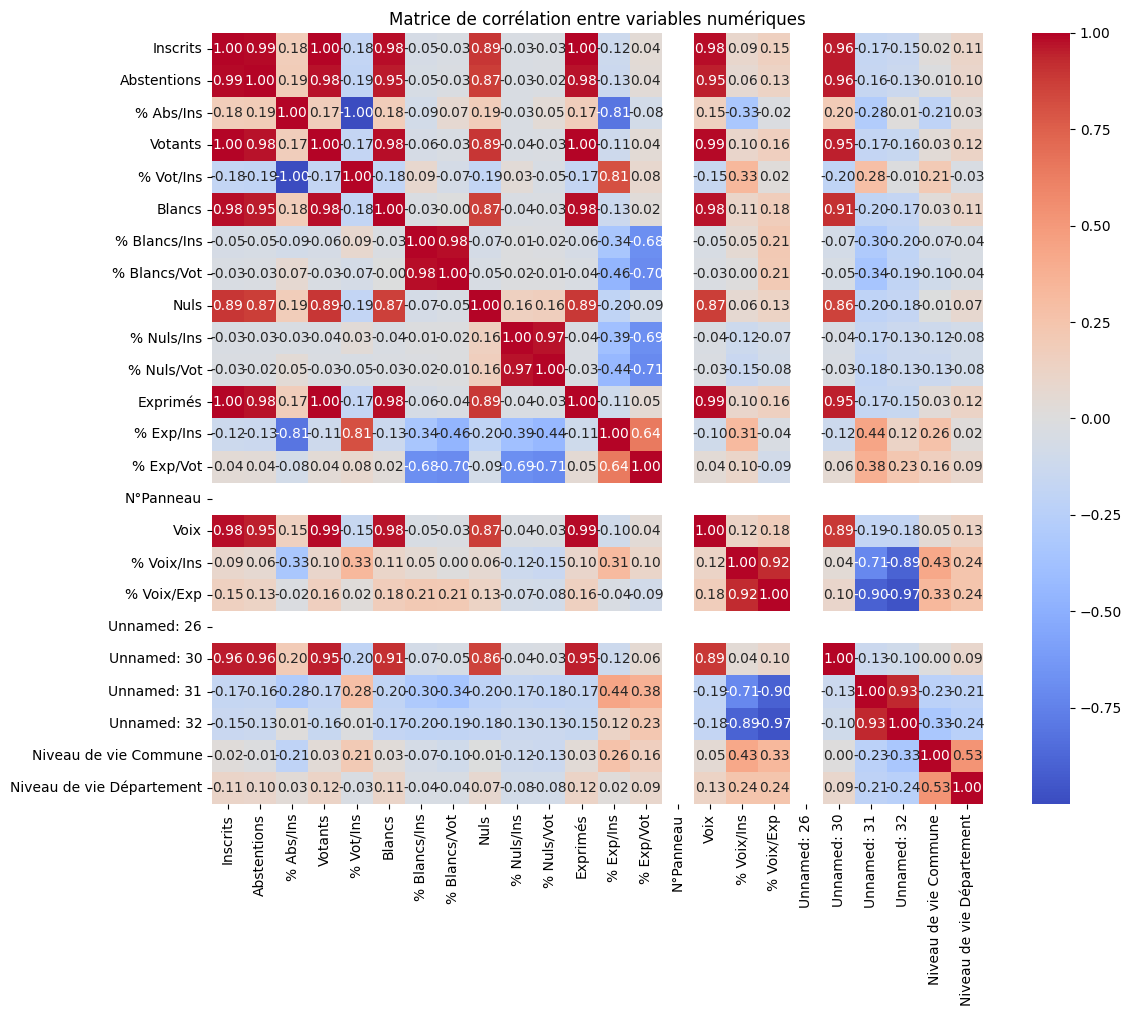

In [ ]:
plt.figure(figsize=(14, 12))
sns.barplot(x=missing_df.index, y='Percentage (%)', data=missing_df)
plt.xticks(rotation=90)
plt.title("Pourcentage de valeurs manquantes par variable")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()

# ----- Visualizations of distributions and outlier detection -----
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col].dropna(), kde=True)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# ----- Correlation matrix between numerical variables -----
plt.figure(figsize=(12, 10))
correlation_matrix = data[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation entre variables numériques")
plt.tight_layout()
plt.show()



In [1]:
# ----- Preparation for the model -----
# Target variable selection: Here we assume it's '% Voix/Ins'
# We remove rows where the target is missing.
data = data.dropna(subset=['% Voix/Ins'])


# Feature selection.
# We choose a few predictor variables.
predictor_columns = ['Inscrits', 'Niveau de vie Commune', 'Niveau de vie Département']
target_column = '% Voix/Ins'


# Extraction of X (features) and y (target)
X = data[predictor_columns]
y = data[target_column]

print("\nVariables sélectionnées pour le modèle :", predictor_columns)
print("Dimension de X :", X.shape)
print("Dimension de y :", y.shape)
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
print("Colonnes numériques sélectionnées :")
print(num_cols)

NameError: name 'data' is not defined


# 3. Models trainning




In [ ]:

# --------- Splitting into training/test sets ---------
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8 ,test_size=0.2,shuffle=True, random_state=1)


## 3.1 Training of the first model (Ridge Regression)

In [ ]:
pipeline_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('model', Ridge())])


## 3.2 Training of the second model (XGboost)

---



In [ ]:
pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipeline_xgb.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])


#  4. Models evaluation





##  4.2 Evaluation of models




✅ RMSE Ridge   : 7.79
⚡ RMSE XGBoost : 6.60


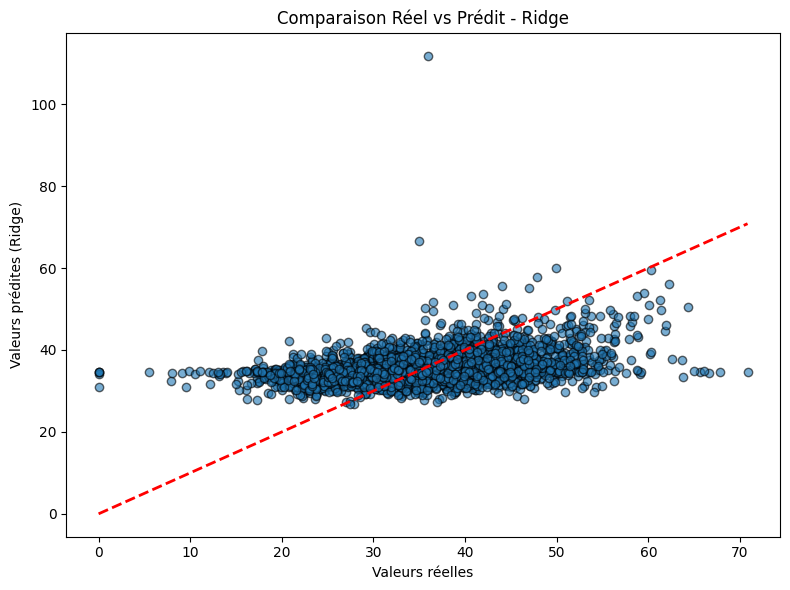

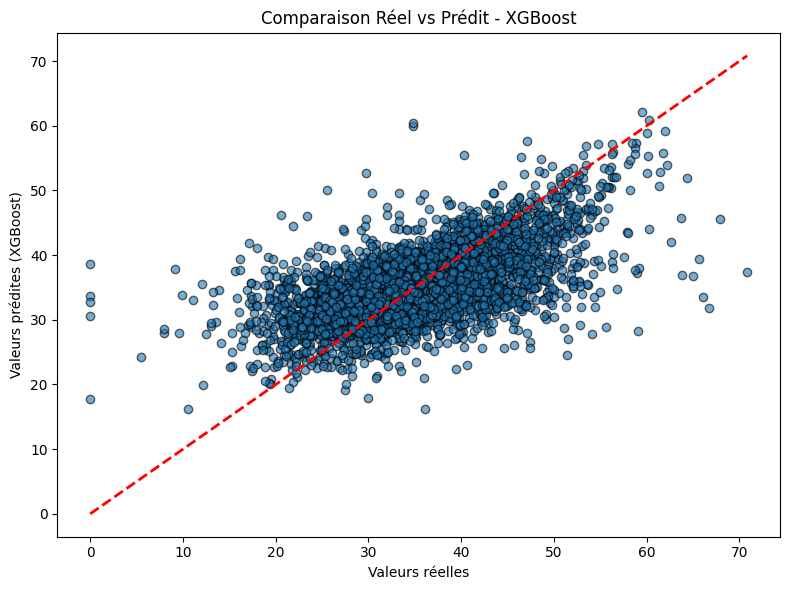

In [ ]:
# --------- Prédictions on the test set ---------
y_pred_ridge = pipeline_ridge.predict(X_test)
y_pred_xgb   = pipeline_xgb.predict(X_test)

# --------- Evaluation ---------
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_xgb   = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"✅ RMSE Ridge   : {rmse_ridge:.2f}")
print(f"⚡ RMSE XGBoost : {rmse_xgb:.2f}")

# --------- Visualisation ---------

# Ridge
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites (Ridge)")
plt.title("Comparaison Réel vs Prédit - Ridge")
plt.tight_layout()
plt.show()

# XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites (XGBoost)")
plt.title("Comparaison Réel vs Prédit - XGBoost")
plt.tight_layout()
plt.show()



###  4.2.1 Optimization of the best model



In [ ]:


def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 1400, 1500),
    "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.03, log=True),
    "max_depth": trial.suggest_int("max_depth", 3, 5),
    "subsample": trial.suggest_float("subsample", 0.95, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.85),
    "gamma": trial.suggest_float("gamma", 0.3, 0.5),
    "min_child_weight": trial.suggest_int("min_child_weight", 8, 12),
    "reg_alpha": trial.suggest_float("reg_alpha", 0.04, 0.06, log=True),
    "reg_lambda": trial.suggest_float("reg_lambda", 0.4, 0.5, log=True),
    "random_state": 42,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1
    }

    # Create a simpler pipeline first to debug
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median', add_indicator=True)),  # Add indicator for missing values
        ('scaler', RobustScaler(quantile_range=(5, 95))),
        ('model', XGBRegressor(**params))
    ])

    # More robust cross-validation with error handling
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

    try:
        # Add error handling for cross validation
        scores = cross_validate(
            pipeline,
            X_train,
            y_train,
            scoring='neg_root_mean_squared_error',
            cv=cv,
            n_jobs=-1,
            error_score='raise'  # This will help us catch errors
        )

        # Check for NaN values
        if np.isnan(np.mean(scores['test_score'])):
            return float('inf')

        return -np.mean(scores['test_score'])

    except Exception as e:
        print(f"Error in trial: {str(e)}")
        return float('inf')

# Create study with more conservative settings
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Add a callback to handle failed trials
def log_failed_trial(study, trial):
    if trial.state == optuna.trial.TrialState.FAIL:
        print(f"Trial {trial.number} failed due to {trial.value}")

# Optimize with the callback
study.optimize(
    objective,
    n_trials=2000,
    show_progress_bar=True,
    callbacks=[log_failed_trial]
)

# Print results
print("\n🏆 Best Trial:")
print(f"RMSE: {-study.best_value:.4f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

[I 2025-05-08 12:06:18,192] A new study created in memory with name: no-name-1485b045-378b-4000-b8b0-263f3b43b68e


  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2025-05-08 12:06:38,174] Trial 0 finished with value: 6.346893702439761 and parameters: {'n_estimators': 1437, 'learning_rate': 0.029406441605774266, 'max_depth': 5, 'subsample': 0.9799329242098518, 'colsample_bytree': 0.7656018640442437, 'gamma': 0.3311989040672405, 'min_child_weight': 8, 'reg_alpha': 0.05683109702236986, 'reg_lambda': 0.4574188470923796}. Best is trial 0 with value: 6.346893702439761.
[I 2025-05-08 12:06:50,029] Trial 1 finished with value: 6.3274673246816775 and parameters: {'n_estimators': 1471, 'learning_rate': 0.020167624432447108, 'max_depth': 5, 'subsample': 0.991622132040021, 'colsample_bytree': 0.7712339110678276, 'gamma': 0.3363649934414201, 'min_child_weight': 8, 'reg_alpha': 0.04525164703497901, 'reg_lambda': 0.4496909463083404}. Best is trial 1 with value: 6.3274673246816775.
[I 2025-05-08 12:06:58,864] Trial 2 finished with value: 6.328174153329233 and parameters: {'n_estimators': 1443, 'learning_rate': 0.022506755945142263, 'max_depth': 4, 'subsample

Écart val/test : 0.1177138458665894
✅ RMSE XGBoost de validation avec Optuna : 6.30
✅ RMSE XGBoost après Optuna (sur l'ensemble de test encore jamais observé) : 6.42


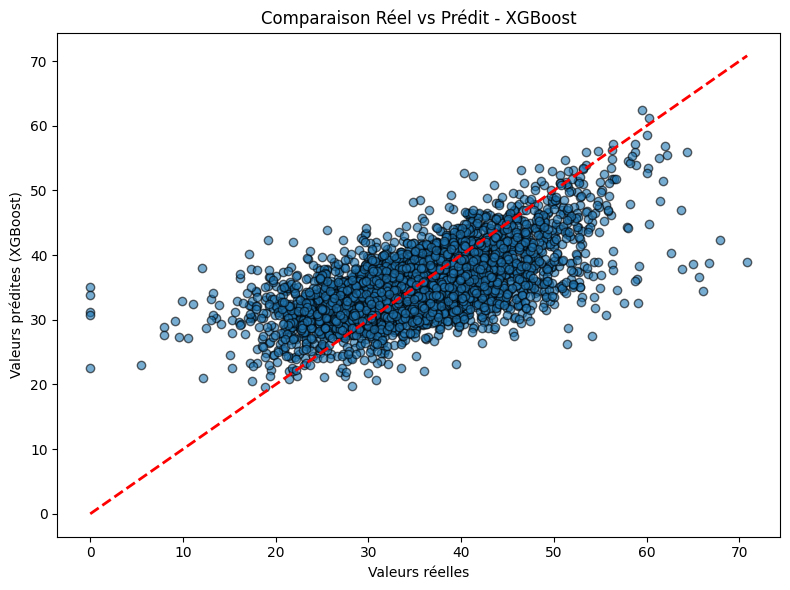

In [ ]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

pipeline_best = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(**best_params))
])

pipeline_best.fit(X_train, y_train)
y_pred_optuna = pipeline_best.predict(X_test)
rmse_optuna = np.sqrt(mean_squared_error(y_test, y_pred_optuna))

val_rmse = study.best_value

print("Écart val/test :", abs(val_rmse - rmse_optuna))
print(f"✅ RMSE XGBoost de validation avec Optuna : {val_rmse:.2f}")
print(f"✅ RMSE XGBoost après Optuna (sur l'ensemble de test encore jamais observé) : {rmse_optuna:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_optuna, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites (XGBoost)")
plt.title("Comparaison Réel vs Prédit - XGBoost")
plt.tight_layout()
plt.show()



#5. Submission Kaggle






In [ ]:
# Loading of the test file
results_test = pd.read_csv('./datasets_intro_ml/results_test.csv', dtype={'CodeINSEE': str})



# Merging with the data used in training
data_test = results_test.merge(niveau_de_vie, on='CodeINSEE', how='left')

# Selecting the predictor columns
X_test = data_test[predictor_columns]


y_pred_optuna = pipeline_best.predict(X_test)


# Adding the prediction to the dataframe
data_test['Prediction'] = y_pred_optuna


# Preparing the submission file (only CodeINSEE + Prediction)
submission = data_test[['CodeINSEE', 'Prediction']]

# Saving the file
submission.to_csv('results_test_predicted.csv', index=False)
print("✅ Fichier de soumission 'results_test_predicted.csv' généré avec succès.")

submission.head()

data_test.head()



✅ Fichier de soumission 'results_test_predicted.csv' généré avec succès.


,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits,Nom Commune,Niveau de vie Commune,Niveau de vie Département,Prediction
0,01001,Ain,L'Abergement-Clémenciat,Complet,643,L'Abergement-Clémenciat,22130.000000,22343.574665,35.591671
1,01002,Ain,L'Abergement-de-Varey,Complet,213,L'Abergement-de-Varey,23213.000000,22343.574665,34.922565
2,01004,Ain,Ambérieu-en-Bugey,Complet,8763,Ambérieu-en-Bugey,19554.000000,22343.574665,36.703831
3,01005,Ain,Ambérieux-en-Dombes,Complet,1282,Ambérieux-en-Dombes,22387.619048,22343.574665,36.649734
4,01007,Ain,Ambronay,Complet,2032,Ambronay,21650.666667,22343.574665,36.072880
